<a href="https://colab.research.google.com/github/rutuja-ramrao/AI-Driven-Cybersecurity-Threat-Prediction-Platform/blob/main/Python_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os, sys, json, math, time, zipfile, pathlib, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

Core libs

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

Viz

In [22]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, roc_curve, auc)

ML

In [23]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

Feature selection

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

 Models

In [25]:
import joblib

print("All imports OK.")

All imports OK.


Persistence

In [26]:
!wget -q -O KDDTrain+.txt https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt
!wget -q -O KDDTest+.txt  https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt

Download from a stable GitHub mirror

In [27]:
kdd_cols = [
 'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment',
 'urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted',
 'num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds',
 'is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
 'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
 'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
 'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label','difficulty'
]

train = pd.read_csv("KDDTrain+.txt", names=kdd_cols)
test  = pd.read_csv("KDDTest+.txt",  names=kdd_cols)

print(train.shape, test.shape)
train.head()

(125973, 43) (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Official 41 feature names + label + difficulty

In [28]:
print("Train nulls:\n", train.isnull().sum().sum())
print("Test  nulls:\n", test.isnull().sum().sum())
print("\nTrain dtypes:\n", train.dtypes.value_counts())
print("\nLabel counts (train):\n", train['label'].value_counts().head())

Train nulls:
 0
Test  nulls:
 0

Train dtypes:
 int64      24
float64    15
object      4
Name: count, dtype: int64

Label counts (train):
 label
normal       67343
neptune      41214
satan         3633
ipsweep       3599
portsweep     2931
Name: count, dtype: int64


Basic sanity checks

In [29]:
# Binary: 1=attack, 0=normal
train['target_bin'] = (train['label'] != 'normal').astype(int)
test['target_bin']  = (test['label']  != 'normal').astype(int)

# Family mapping
dos = ['back','land','neptune','pod','smurf','teardrop','apache2','udpstorm','processtable','worm']
probe = ['satan','ipsweep','nmap','portsweep','mscan','saint']
r2l = ['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
u2r = ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

def family_map(lbl):
    if lbl == 'normal': return 'normal'
    if lbl in dos: return 'dos'
    if lbl in probe: return 'probe'
    if lbl in r2l: return 'r2l'
    if lbl in u2r: return 'u2r'
    return 'other'

train['family'] = train['label'].apply(family_map)
test['family']  = test['label'].apply(family_map)

print(train[['label','family','target_bin']].head(10))
print("\nFamily distribution (train):\n", train['family'].value_counts())


     label  family  target_bin
0   normal  normal           0
1   normal  normal           0
2  neptune     dos           1
3   normal  normal           0
4   normal  normal           0
5  neptune     dos           1
6  neptune     dos           1
7  neptune     dos           1
8  neptune     dos           1
9  neptune     dos           1

Family distribution (train):
 family
normal    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


Convert label to binary (attack vs normal) and multi-class fa

In [30]:
print("Train:", train.shape, " Test:", test.shape)
display(train.head(3))
display(train.describe(include='all').T.head(12))


Train: (125973, 45)  Test: (22544, 45)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty,target_bin,family
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.0,0.0,0.0,0.05,0.0,normal,20,0,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.0,0.0,0.0,0.00,0.0,normal,15,0,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19,1,dos


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
duration,125973.0,NaN,NaN,NaN,287.14465,2604.51531,0.0,0.0,0.0,0.0,42908.0
protocol_type,125973,3,tcp,102689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service,125973,70,http,40338,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flag,125973,11,SF,74945,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_bytes,125973.0,NaN,NaN,NaN,45566.743,5870331.181891,0.0,0.0,44.0,276.0,1379963888.0
dst_bytes,125973.0,NaN,NaN,NaN,19779.114421,4021269.15144,0.0,0.0,0.0,516.0,1309937401.0
land,125973.0,NaN,NaN,NaN,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
wrong_fragment,125973.0,NaN,NaN,NaN,0.022687,0.25353,0.0,0.0,0.0,0.0,3.0
urgent,125973.0,NaN,NaN,NaN,0.000111,0.014366,0.0,0.0,0.0,0.0,3.0
hot,125973.0,NaN,NaN,NaN,0.204409,2.149968,0.0,0.0,0.0,0.0,77.0


Quick EDA — shapes, head, describe

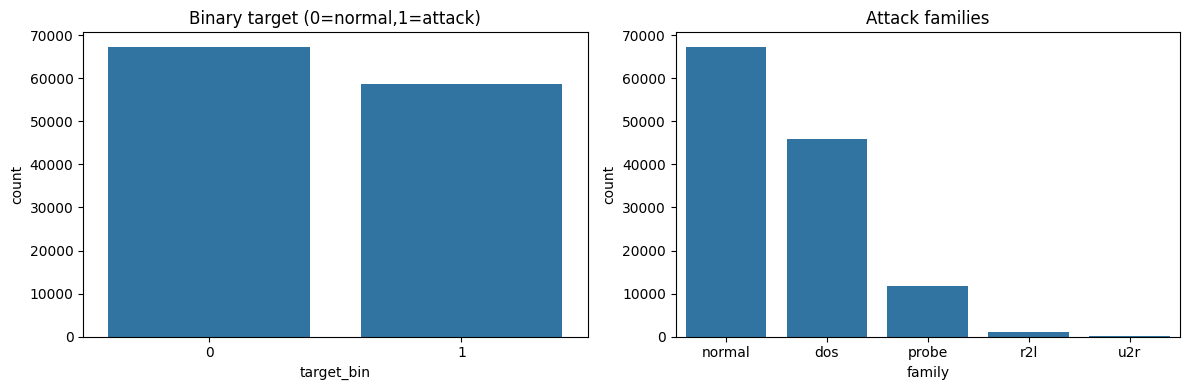

In [31]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(data=train, x='target_bin', ax=axes[0])
axes[0].set_title('Binary target (0=normal,1=attack)')
sns.countplot(data=train, x='family', order=train['family'].value_counts().index, ax=axes[1])
axes[1].set_title('Attack families')
plt.tight_layout(); plt.show()


Class balance plots (binary and family)

In [32]:
for col in ['protocol_type','service','flag']:
    print(f"{col} unique ({train[col].nunique()}): {sorted(train[col].unique()[:10])} ...")


protocol_type unique (3): ['icmp', 'tcp', 'udp'] ...
service unique (70): ['eco_i', 'ftp_data', 'http', 'mtp', 'name', 'netbios_ns', 'other', 'private', 'remote_job', 'telnet'] ...
flag unique (11): ['REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH'] ...


Categorical feature levels

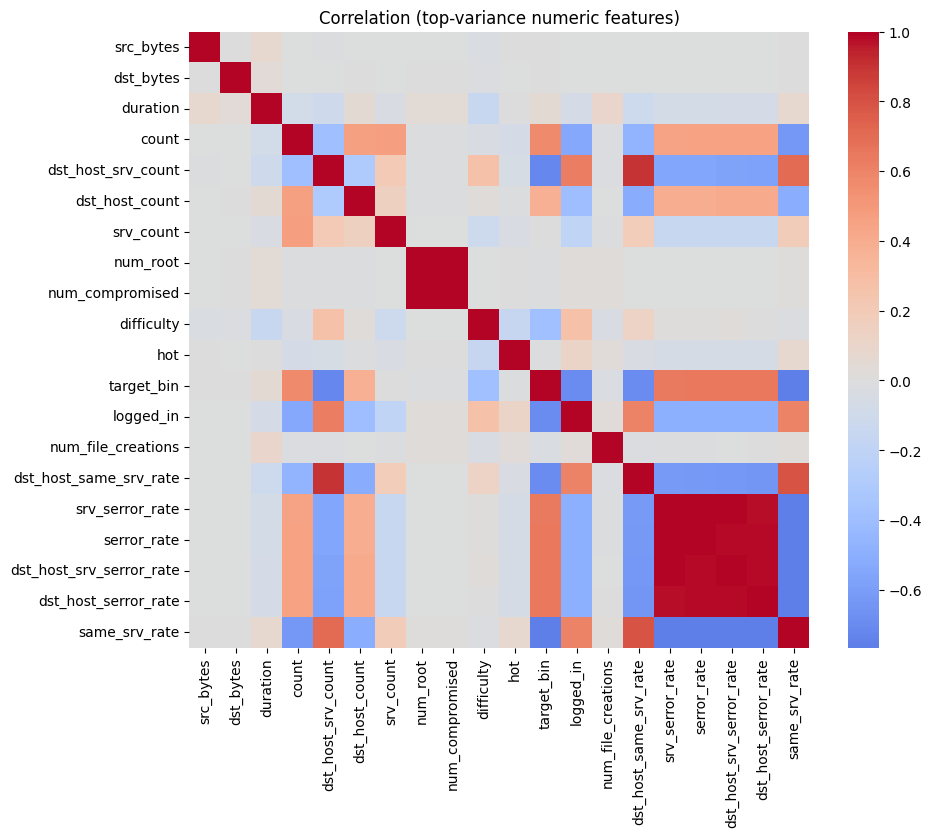

In [33]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
corr = train[num_cols].corr()
# pick top 20 most variable features to keep heatmap readable
top20 = train[num_cols].var().sort_values(ascending=False).head(20).index
plt.figure(figsize=(10,8))
sns.heatmap(train[top20].corr(), cmap='coolwarm', center=0)
plt.title("Correlation (top-variance numeric features)")
plt.show()


Numeric correlation heatmap (top 20 by variance)

In [34]:
TARGET = 'target_bin'
drop_cols = ['label','difficulty','family', TARGET]  # drop when selecting X

categorical = ['protocol_type','service','flag']
numeric = [c for c in train.columns if c not in drop_cols + categorical]

X_train_raw = train[categorical + numeric]
y_train = train[TARGET]
X_test_raw  = test[categorical + numeric]
y_test  = test[TARGET]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', StandardScaler(with_mean=False), numeric)  # with_mean=False for sparse safety
    ]
)


Prepare features/target and preprocess

In [35]:
lr_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=200, n_jobs=None))  # n_jobs only in liblinear? keep default
])
lr_clf.fit(X_train_raw, y_train)
pred_lr = lr_clf.predict(X_test_raw)
proba_lr = lr_clf.predict_proba(X_test_raw)[:,1]

print("LogReg Acc:", accuracy_score(y_test, pred_lr))
print("LogReg F1 :", f1_score(y_test, pred_lr))
print("LogReg ROC AUC:", roc_auc_score(y_test, proba_lr))


LogReg Acc: 0.7531937544357701
LogReg F1 : 0.7417138612942159
LogReg ROC AUC: 0.7928499890103023


Baseline model: Logistic Regression (pipeline)

In [36]:
rf_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=2,
        n_jobs=-1, random_state=42, class_weight='balanced_subsample'
    ))
])
rf_clf.fit(X_train_raw, y_train)
pred_rf = rf_clf.predict(X_test_raw)
proba_rf = rf_clf.predict_proba(X_test_raw)[:,1]

print("RF Acc:", accuracy_score(y_test, pred_rf))
print("RF F1 :", f1_score(y_test, pred_rf))
print("RF ROC AUC:", roc_auc_score(y_test, proba_rf))


RF Acc: 0.7731990773598296
RF F1 : 0.7574593235615009
RF ROC AUC: 0.9616683470781385
